In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pystan

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [2]:
import pymc3 as pm
import theano
import theano.tensor as T
from scipy.stats.stats import pearsonr

In [3]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [4]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser, host='/var/run/postgresql')
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [5]:
query = """
SELECT * FROM icu_features
"""
ef = pd.read_sql_query(query, con)
ef.head()

,icustay_id,hadm_id,subject_id,age,gender,height,weight,ethnicity,insurance,filter_vaso,...,pc_bronch,pc_cath,pc_echo,pc_pressor,pc_rhc,pc_thora,pc_vent,passed_filters,use_record,bmi
0,200001,152234,55973,22290 days 19:06:12,F,167.851667,27.669135,ASIAN - ASIAN INDIAN,Medicare,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,9.820741
1,200003,163557,27513,17625 days 19:50:04,M,177.800000,78.224998,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,24.744692
2,200006,189514,10950,19736 days 11:28:14,M,165.100000,82.400002,OTHER,Medicaid,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.229647
3,200007,129310,20707,15818 days 10:03:37,M,177.800000,126.000000,WHITE,Private,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.857223
4,200009,129607,29904,17353 days 10:34:32,F,160.020000,85.833331,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,33.520264


In [6]:
len(ef)

61532

In [7]:
F = (ef['use_record'] == 1)

In [8]:
ef = ef.loc[F]
len(ef)

9320

## Calculate MDRD and add to features table

In [9]:
def mdrd(data):
    creat = data.lab_creatinine
    age = data.age/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender.apply(lambda x: 0.742 if x == 'F' else 1)
    ethnicity = data.ethnicity.apply(lambda x: 1.212 if 'AFRICAN AMERICAN' in x else 1)
    return 175*creat**(-1.154) * age**(-0.203) * gender * ethnicity

In [10]:
value = mdrd(ef)
ef['mdrd'] = value
discrete = pd.cut(value, [0, 15, 30, 44, 60, 90, 1000000], labels=[5, 4, 3, 2, 1, 0], include_lowest=True)
ef['mdrd_discrete'] = discrete
discrete.value_counts()

0    2524
1    2068
2    1439
4    1280
3    1258
5     503
dtype: int64

In [11]:
discrete = pd.cut(value, [0, 30, 60, 1000000], labels=[2, 1, 0], include_lowest=True)
ef['mdrd_3'] = discrete
discrete.value_counts()

0    4592
1    2697
2    1783
dtype: int64

## Create general features table

In [12]:
def normalize(x):
    x = x.copy()
    I = ~np.isnan(x)
    x[I] = (x[I] - x[I].mean())/x[I].std()
    return x

In [13]:
## is apache score everr missing?
sum(np.isnan(ef.apsiii))

0

In [14]:
X = pd.DataFrame()

# build the features table
age = ef.age/np.timedelta64('1', 'Y') # time in years
age_masked = age < 0 # if age is less than 0, then the person is above 89 (90?)
age = normalize(age)
age[age_masked] = 0
X['age'] = age
X['age_over_90'] = age_masked.astype(float)

gender = ef.gender
gender = (gender == 'F').astype(float)
X['gender'] = gender

bmi = ef.bmi
bmi_missing = np.isnan(bmi)
bmi = normalize(bmi)
bmi[bmi_missing] = 0
X['bmi'] = bmi
X['bmi_missing'] = bmi_missing.astype(float)

mech_vent = ef.vf_first_day_vent.astype(float)
X['mech_vent'] = mech_vent

chf = ef.ex_congestive_heart_failure.astype(float)
X['CHF'] = chf

mdrd = ef.mdrd
mdrd_missing = np.isnan(mdrd)
mdrd = normalize(mdrd)
mdrd[mdrd_missing] = 0
X['mdrd'] = mdrd

# MDRD missing is already largely covered by BMI missing
# the only other missing values come from missing creatinine lab
# so add that
creatinine_missing = np.isnan(ef.lab_creatinine)
X['creatinine_missing'] = creatinine_missing.astype(float)

apsiii = ef.apsiii
#apsiii_missing = np.isnan(apsiii)
apsiii = normalize(apsiii)
#apsiii[apsiii_missing] = 0
X['apsiii'] = apsiii
#X['apsiii_missing'] = apsiii_missing.astype(float)

lvsys = ef.ea_lv_systolic
lv_missing = np.isnan(lvsys).astype(float)
lv_normal = (lvsys == 0).astype(float)
lv_hyperdynamic = (lvsys == -1).astype(float)
lv_mild_depressed = (lvsys == 1).astype(float)
lv_mod_depressed = (lvsys == 2).astype(float)
lv_sev_depressed = (lvsys == 3).astype(float)
X['lv_missing'] = lv_missing
X['lv_normal'] = lv_normal
X['lv_hyper'] = lv_hyperdynamic
X['lv_mild'] = lv_mild_depressed
X['lv_moderate'] = lv_mod_depressed
X['lv_severe'] = lv_sev_depressed

lactate = ef.lab_lactate
lactate_missing = np.isnan(lactate)
lactate = normalize(lactate)
lactate[lactate_missing] = 0
X['lactate'] = lactate
X['lactate_missing'] = lactate_missing.astype(float)

X.head()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,lv_missing,lv_normal,lv_hyper,lv_mild,lv_moderate,lv_severe,lactate,lactate_missing
1,0.100055,0.0,0.0,-0.002727,0.0,1.0,0.0,0.436365,0.0,-0.204530,0.0,0.0,0.0,0.0,1.0,0.0,0.716411,0.0
16,0.450966,0.0,1.0,0.000000,1.0,0.0,1.0,0.000000,1.0,0.364830,1.0,0.0,0.0,0.0,0.0,0.0,3.776100,0.0
20,0.164522,0.0,0.0,0.044261,0.0,0.0,0.0,0.404471,0.0,0.145846,0.0,1.0,0.0,0.0,0.0,0.0,0.065522,0.0
22,0.305922,0.0,0.0,-0.088287,0.0,0.0,0.0,0.729504,0.0,-1.036671,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0
25,0.390890,0.0,0.0,0.000000,1.0,0.0,0.0,-0.400352,0.0,2.204301,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0


## Some helper model building functions

In [15]:
def ridge(X, y, l=1.0):
    n = X.shape[1]
    beta = pm.Normal('beta', 0, l, shape=n)
    intercept = pm.Flat('intercept')
    
    # observation error
    sigma = pm.HalfCauchy('sigma', 5)
    
    yh = T.dot(X, beta) + intercept
    ydist = pm.Normal('y', mu=yh, sd=sigma, observed=y)

In [16]:
def logistic(X, y, l=1.0):
    n = X.shape[1]
    beta = pm.Normal('beta', 0, l, shape=n)
    intercept = pm.Flat('intercept')
    
    yh = T.nnet.sigmoid(T.dot(X, beta) + intercept)
    ydist = pm.Bernoulli('y', yh, observed=y)

## Simple linear model for predicting fluid balance on day 1

In [40]:
## predictive model of fluids given
y_fluid = ef.fb_day1_balance_ml
missing = np.isnan(y_fluid) | ef.fb_day1_balance_truncated
np.sum(missing)

991

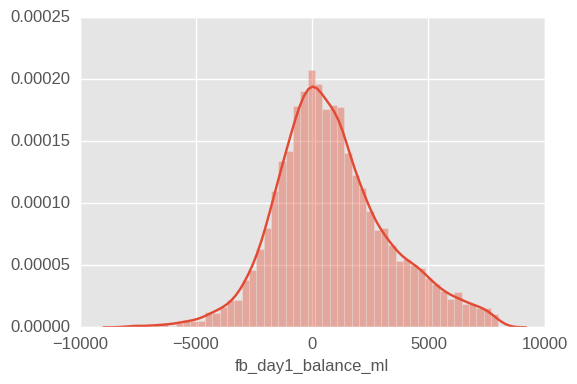

In [20]:
sns.distplot(ef.fb_day1_balance_ml[~missing])

In [23]:
X_fluid = X.loc[~missing]
y_fluid = normalize(y_fluid[~missing])
len(y_fluid)

8329

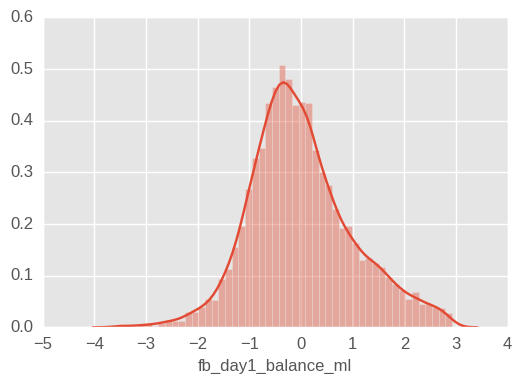

In [24]:
sns.distplot(y_fluid)

In [25]:
with pm.Model() as model:
    #pm.glm.glm('y ~ x', data)
    ridge(X_fluid, y_fluid)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(2000, step)

         Current function value: 11103.783108
         Iterations: 42
         Function evaluations: 56
         Gradient evaluations: 55


100%|██████████| 2000/2000 [00:28<00:00, 70.68it/s] 


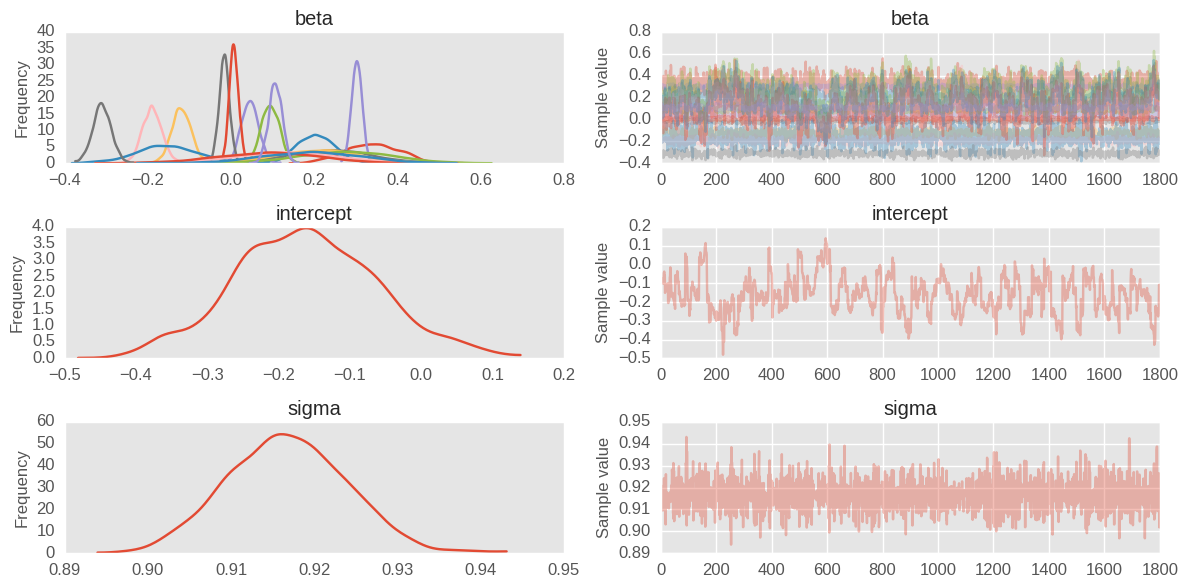

In [26]:
_ = pm.traceplot(trace[200:])

In [27]:
sample_coefs = pd.DataFrame(trace[200:]['beta'], columns=X_fluid.columns)
sample_coefs['intercept'] = trace[200:]['intercept']
sample_coefs.head()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,lv_missing,lv_normal,lv_hyper,lv_mild,lv_moderate,lv_severe,lactate,lactate_missing,intercept
0,0.286433,0.204876,0.071173,-0.016972,-0.121190,0.089676,-0.200401,0.006084,-0.136530,0.288380,0.136407,0.127832,0.208681,0.096818,-0.115265,0.127061,0.136563,-0.334478,-0.073363
1,0.317202,0.166947,0.003989,-0.017661,-0.142233,0.076146,-0.187076,0.009387,-0.082427,0.320540,0.218010,0.190035,0.299965,0.085540,0.156814,0.168167,0.093476,-0.314130,-0.081025
2,0.317202,0.166947,0.003989,-0.017661,-0.142233,0.076146,-0.187076,0.009387,-0.082427,0.320540,0.218010,0.190035,0.299965,0.085540,0.156814,0.168167,0.093476,-0.314130,-0.081025
3,0.310702,0.201373,-0.007349,-0.027373,-0.131266,0.061189,-0.169934,0.010065,-0.139488,0.301662,0.207570,0.187424,0.292315,0.095498,0.117715,0.204401,0.098382,-0.311763,-0.102283
4,0.302833,0.172207,0.022852,-0.011975,-0.141348,0.104165,-0.169270,0.010168,-0.063850,0.308567,0.201562,0.180078,0.247918,0.032918,0.085269,0.075883,0.114449,-0.297872,-0.090828


In [28]:
sample_coefs.describe()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,lv_missing,lv_normal,lv_hyper,lv_mild,lv_moderate,lv_severe,lactate,lactate_missing,intercept
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.339050,0.202451,0.045064,-0.016365,-0.119287,0.094804,-0.189562,0.006617,-0.155142,0.302288,0.235350,0.208123,0.276285,0.131166,0.089925,0.192638,0.106667,-0.310480,-0.161794
std,0.063406,0.044429,0.020258,0.011799,0.023339,0.021036,0.023422,0.010870,0.073360,0.012183,0.096986,0.097719,0.110317,0.118243,0.123103,0.116112,0.015956,0.021990,0.099208
min,0.140668,0.057085,-0.034371,-0.050838,-0.199569,0.026090,-0.277298,-0.032490,-0.382718,0.264964,-0.049296,-0.076796,-0.090030,-0.247000,-0.326828,-0.225822,0.044838,-0.374573,-0.481200
25%,0.293404,0.171890,0.031075,-0.024281,-0.133991,0.079837,-0.205615,-0.000722,-0.203078,0.294130,0.169059,0.141511,0.200265,0.049095,0.006014,0.111492,0.096309,-0.324499,-0.232051
50%,0.339156,0.202150,0.045346,-0.016364,-0.119601,0.094691,-0.190143,0.006497,-0.156150,0.302409,0.236765,0.209894,0.278793,0.132205,0.092541,0.195628,0.106700,-0.310718,-0.163638
75%,0.384569,0.233016,0.058913,-0.008432,-0.103483,0.109740,-0.174287,0.014062,-0.106201,0.310788,0.300898,0.273900,0.354602,0.211862,0.173713,0.274865,0.117765,-0.295740,-0.094959
max,0.558135,0.360986,0.118724,0.016925,-0.046635,0.162946,-0.104581,0.039117,0.090938,0.338924,0.513875,0.484884,0.626318,0.538850,0.544138,0.542392,0.161996,-0.235022,0.139160


In [29]:
W = sample_coefs.values[:,:X_fluid.shape[1]]
b = sample_coefs['intercept'].values

y_ppc = np.dot(X_fluid.values, W.T) + b
y_ppc = y_ppc.T

In [30]:
r2_ppc = np.zeros(len(y_ppc))
for i in range(len(y_ppc)):
    yh = y_ppc[i]
    r = pearsonr(yh, y_fluid)[0]
    r2_ppc[i] = r**2

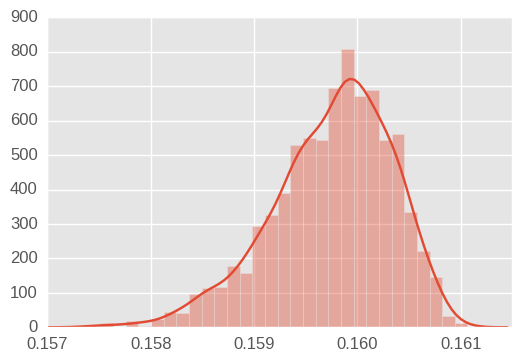

In [31]:
sns.distplot(r2_ppc)

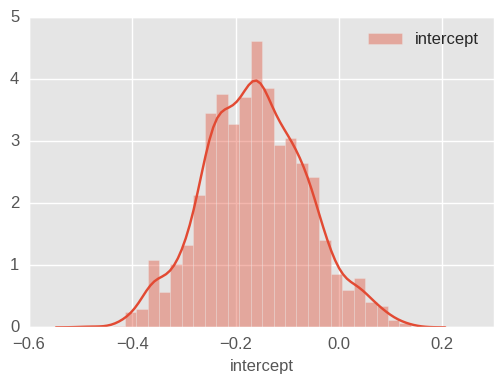

In [32]:
coefs = ['intercept']
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
_ = plt.legend(loc='best')

,age,age_over_90,gender,bmi,bmi_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.339050,0.202451,0.045064,-0.016365,-0.119287
std,0.063406,0.044429,0.020258,0.011799,0.023339
min,0.140668,0.057085,-0.034371,-0.050838,-0.199569
25%,0.293404,0.171890,0.031075,-0.024281,-0.133991
50%,0.339156,0.202150,0.045346,-0.016364,-0.119601
75%,0.384569,0.233016,0.058913,-0.008432,-0.103483
max,0.558135,0.360986,0.118724,0.016925,-0.046635


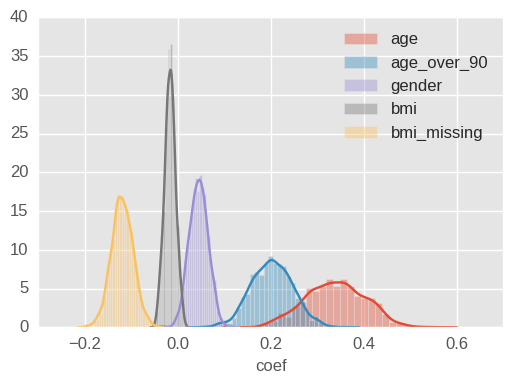

In [33]:
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,mech_vent,CHF,apsiii,mdrd,creatinine_missing,lactate,lactate_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.094804,-0.189562,0.302288,0.006617,-0.155142,0.106667,-0.310480
std,0.021036,0.023422,0.012183,0.010870,0.073360,0.015956,0.021990
min,0.026090,-0.277298,0.264964,-0.032490,-0.382718,0.044838,-0.374573
25%,0.079837,-0.205615,0.294130,-0.000722,-0.203078,0.096309,-0.324499
50%,0.094691,-0.190143,0.302409,0.006497,-0.156150,0.106700,-0.310718
75%,0.109740,-0.174287,0.310788,0.014062,-0.106201,0.117765,-0.295740
max,0.162946,-0.104581,0.338924,0.039117,0.090938,0.161996,-0.235022


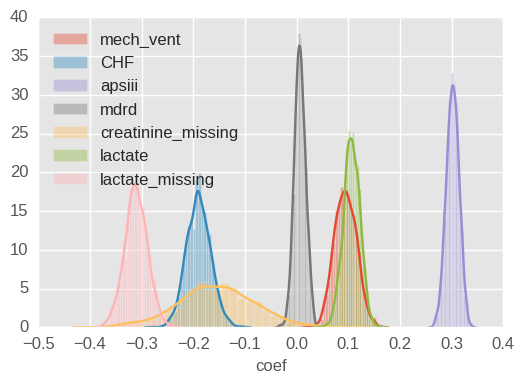

In [34]:
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,lv_missing,lv_normal,lv_hyper,lv_mild,lv_moderate,lv_severe
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.235350,0.208123,0.276285,0.131166,0.089925,0.192638
std,0.096986,0.097719,0.110317,0.118243,0.123103,0.116112
min,-0.049296,-0.076796,-0.090030,-0.247000,-0.326828,-0.225822
25%,0.169059,0.141511,0.200265,0.049095,0.006014,0.111492
50%,0.236765,0.209894,0.278793,0.132205,0.092541,0.195628
75%,0.300898,0.273900,0.354602,0.211862,0.173713,0.274865
max,0.513875,0.484884,0.626318,0.538850,0.544138,0.542392


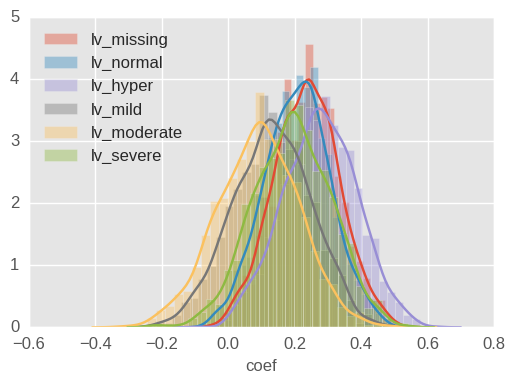

In [35]:
coefs = ['lv_missing', 'lv_normal', 'lv_hyper', 'lv_mild', 'lv_moderate', 'lv_severe']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

## Simple linear model for predicting 30-day mortality

In [53]:
## make the features table. include fluid balance on days 1,2,3 of ICU stay
X_mortality = X.copy()

fluid_day1 = ef.fb_day1_balance_ml.values
fl_missing = np.isnan(fluid_day1) | ef.fb_day1_balance_truncated.eq(1).values # also filter insane fluid balances
fluid_day1[~fl_missing] = normalize(fluid_day1[~fl_missing])
fluid_day1[fl_missing] = 0
X_mortality['fluid_day1'] = fluid_day1
X_mortality['fluid_day1_missing'] = fl_missing.astype(float)

fluid_day2 = ef.fb_day2_balance_ml.values
fl_missing = np.isnan(fluid_day2) | ef.fb_day2_balance_truncated.eq(1).values
fluid_day2[~fl_missing] = normalize(fluid_day2[~fl_missing])
fluid_day2[fl_missing] = 0
X_mortality['fluid_day2'] = fluid_day2
X_mortality['fluid_day2_missing'] = fl_missing.astype(float)

fluid_day3 = ef.fb_day3_balance_ml.values
fl_missing = np.isnan(fluid_day3) | ef.fb_day3_balance_truncated.eq(1).values
fluid_day3[~fl_missing] = normalize(fluid_day3[~fl_missing])
fluid_day3[fl_missing] = 0
X_mortality['fluid_day3'] = fluid_day3
X_mortality['fluid_day3_missing'] = fl_missing.astype(float)

In [54]:
y_mortality = (ef.dod - ef.intime) < np.timedelta64(30, 'D')
y_mortality = y_mortality.astype(float)
y_mortality.mean(), y_mortality.sum(), len(y_mortality)

(0.2811158798283262, 2620.0, 9320)

In [55]:
with pm.Model() as model:
    #pm.glm.glm('y ~ x', data)
    logistic(X_mortality, y_mortality)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(2000, step)

         Current function value: 4600.192823
         Iterations: 37
         Function evaluations: 115
         Gradient evaluations: 104


100%|██████████| 2000/2000 [03:10<00:00, 10.50it/s]


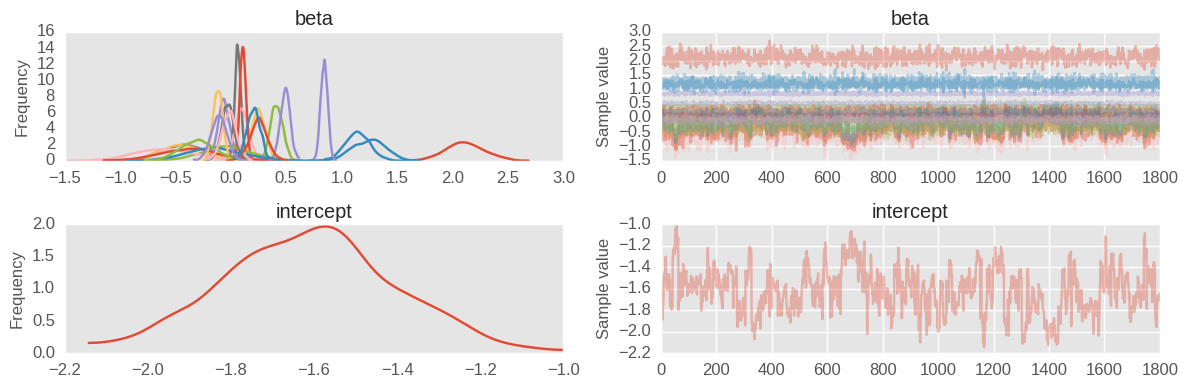

In [56]:
_ = pm.traceplot(trace[200:])

In [57]:
sample_coefs = pd.DataFrame(trace[200:]['beta'], columns=X_mortality.columns)
sample_coefs['intercept'] = trace[200:]['intercept']
sample_coefs.head()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,...,lv_severe,lactate,lactate_missing,fluid_day1,fluid_day1_missing,fluid_day2,fluid_day2_missing,fluid_day3,fluid_day3_missing,intercept
0,2.068561,1.093881,-0.087551,0.104414,0.298224,0.504366,0.120700,0.051929,1.003589,0.792400,...,-0.231792,0.602946,0.006567,-0.117479,-0.241971,0.075981,0.252575,0.080746,-0.080777,-1.713574
1,1.950075,1.070905,-0.058503,0.024504,0.212307,0.423507,0.133771,0.136386,1.395172,0.878772,...,0.036311,0.390086,-0.006382,-0.203129,-0.510157,0.102676,0.250538,0.191991,-0.131532,-1.654813
2,1.950075,1.070905,-0.058503,0.024504,0.212307,0.423507,0.133771,0.136386,1.395172,0.878772,...,0.036311,0.390086,-0.006382,-0.203129,-0.510157,0.102676,0.250538,0.191991,-0.131532,-1.654813
3,2.098918,1.199572,-0.096951,0.094131,0.270408,0.394745,0.106919,0.074294,1.136091,0.816116,...,-0.348285,0.552754,-0.018311,-0.145452,-0.415038,0.115453,0.150044,0.072092,0.023637,-1.583198
4,2.007639,1.184209,-0.016020,0.036890,0.266521,0.427397,0.137158,0.110939,1.165335,0.889393,...,-0.096996,0.472423,-0.019667,-0.151622,-0.064687,-0.011600,0.306473,0.166171,-0.183868,-1.555893


In [58]:
sample_coefs.describe()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,...,lv_severe,lactate,lactate_missing,fluid_day1,fluid_day1_missing,fluid_day2,fluid_day2_missing,fluid_day3,fluid_day3_missing,intercept
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,...,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,2.114737,1.143085,-0.065095,0.064140,0.246457,0.411393,0.096164,0.107454,1.245992,0.841414,...,-0.156989,0.490371,-0.029615,-0.118591,-0.303203,-0.015837,0.247003,0.203615,-0.108022,-1.612166
std,0.171314,0.109227,0.052588,0.030204,0.060968,0.055352,0.061555,0.027963,0.146809,0.030972,...,0.246776,0.043782,0.056631,0.042245,0.153739,0.065959,0.080436,0.059096,0.069824,0.205937
min,1.649090,0.851814,-0.241808,-0.033599,0.063920,0.224217,-0.157161,0.012921,0.707354,0.745983,...,-0.937621,0.347711,-0.227454,-0.251044,-0.781220,-0.211988,-0.038421,0.033683,-0.334733,-2.141804
25%,1.998175,1.069695,-0.099357,0.045400,0.205554,0.374765,0.055567,0.089070,1.139059,0.819698,...,-0.323910,0.461063,-0.064824,-0.147388,-0.408922,-0.059663,0.196333,0.162931,-0.154391,-1.755096
50%,2.109119,1.141103,-0.065375,0.062777,0.246332,0.411594,0.095770,0.107359,1.251351,0.842144,...,-0.159402,0.491268,-0.028895,-0.117774,-0.299132,-0.014297,0.248000,0.205104,-0.108722,-1.611267
75%,2.227783,1.217800,-0.029916,0.082166,0.288571,0.449791,0.136044,0.126133,1.346590,0.862856,...,0.008780,0.519681,0.007546,-0.088889,-0.198541,0.026188,0.299042,0.243475,-0.062192,-1.483612
max,2.685463,1.581866,0.086165,0.178734,0.450376,0.590302,0.324372,0.200169,1.704019,0.946207,...,0.747441,0.614500,0.149205,0.026761,0.146949,0.187684,0.510359,0.376220,0.142094,-1.001390


In [59]:
W = sample_coefs.values[:,:X_mortality.shape[1]]
b = sample_coefs['intercept'].values

y_ppc = np.dot(X_mortality.values, W.T) + b
y_ppc = y_ppc.T
y_ppc.shape, y_mortality.shape

((1800, 9320), (9320,))

In [60]:
acc_ppc = (y_ppc > 0).astype(float) == y_mortality.values
acc_ppc = acc_ppc.mean(axis=1)

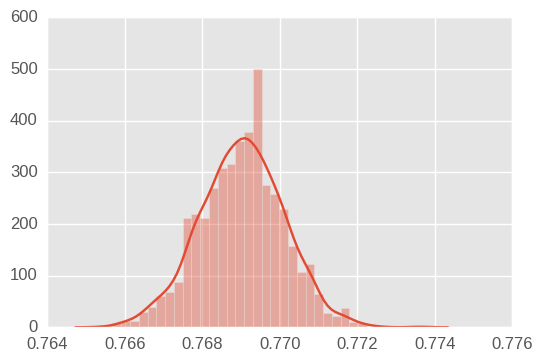

In [61]:
sns.distplot(acc_ppc)

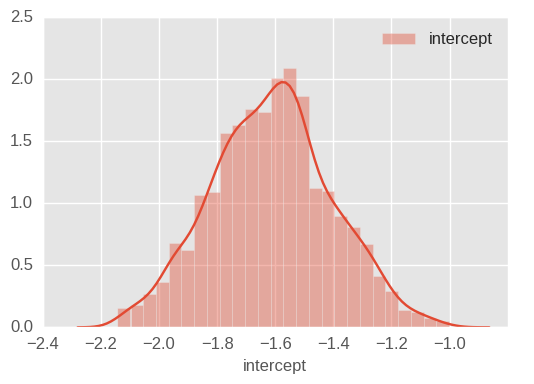

In [62]:
coefs = ['intercept']
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
_ = plt.legend(loc='best')

,age,age_over_90,gender,bmi,bmi_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,2.114737,1.143085,-0.065095,0.064140,0.246457
std,0.171314,0.109227,0.052588,0.030204,0.060968
min,1.649090,0.851814,-0.241808,-0.033599,0.063920
25%,1.998175,1.069695,-0.099357,0.045400,0.205554
50%,2.109119,1.141103,-0.065375,0.062777,0.246332
75%,2.227783,1.217800,-0.029916,0.082166,0.288571
max,2.685463,1.581866,0.086165,0.178734,0.450376


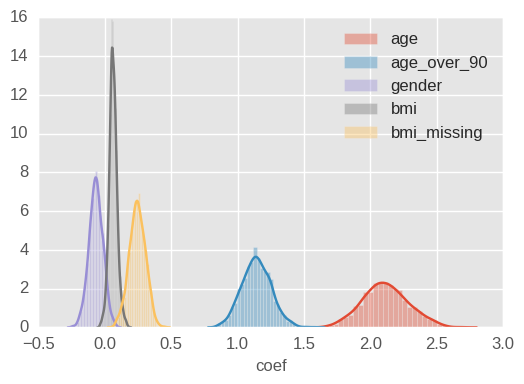

In [63]:
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,mech_vent,CHF,apsiii,mdrd,creatinine_missing,lactate,lactate_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.411393,0.096164,0.841414,0.107454,1.245992,0.490371,-0.029615
std,0.055352,0.061555,0.030972,0.027963,0.146809,0.043782,0.056631
min,0.224217,-0.157161,0.745983,0.012921,0.707354,0.347711,-0.227454
25%,0.374765,0.055567,0.819698,0.089070,1.139059,0.461063,-0.064824
50%,0.411594,0.095770,0.842144,0.107359,1.251351,0.491268,-0.028895
75%,0.449791,0.136044,0.862856,0.126133,1.346590,0.519681,0.007546
max,0.590302,0.324372,0.946207,0.200169,1.704019,0.614500,0.149205


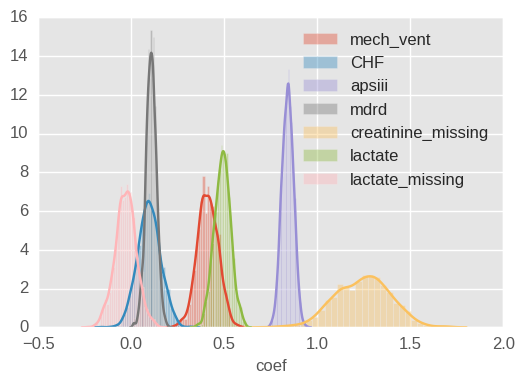

In [64]:
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,lv_missing,lv_normal,lv_hyper,lv_mild,lv_moderate,lv_severe
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.439836,-0.448922,-0.043099,-0.601589,-0.370199,-0.156989
std,0.196679,0.199315,0.224698,0.265232,0.267504,0.246776
min,-1.078546,-1.166168,-0.803155,-1.467949,-1.149603,-0.937621
25%,-0.573162,-0.578594,-0.183875,-0.784108,-0.555775,-0.323910
50%,-0.435577,-0.446995,-0.040772,-0.604071,-0.369028,-0.159402
75%,-0.300477,-0.310231,0.100158,-0.417390,-0.204210,0.008780
max,0.166905,0.115050,0.646075,0.266015,0.609698,0.747441


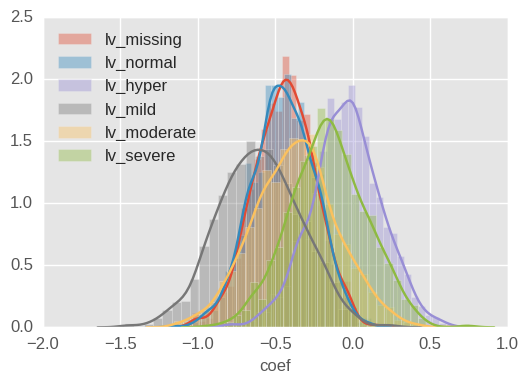

In [65]:
coefs = ['lv_missing', 'lv_normal', 'lv_hyper', 'lv_mild', 'lv_moderate', 'lv_severe']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,fluid_day1,fluid_day2,fluid_day3
count,1800.000000,1800.000000,1800.000000
mean,-0.118591,-0.015837,0.203615
std,0.042245,0.065959,0.059096
min,-0.251044,-0.211988,0.033683
25%,-0.147388,-0.059663,0.162931
50%,-0.117774,-0.014297,0.205104
75%,-0.088889,0.026188,0.243475
max,0.026761,0.187684,0.376220


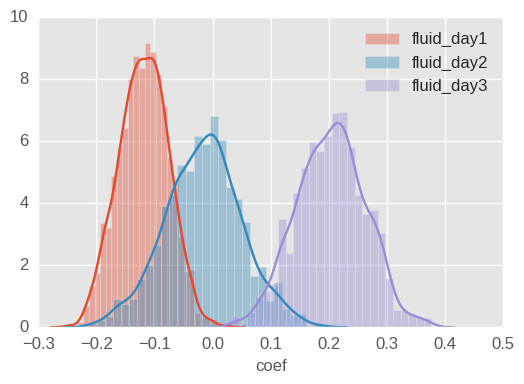

In [66]:
coefs = ['fluid_day1', 'fluid_day2', 'fluid_day3']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,fluid_day1_missing,fluid_day2_missing,fluid_day3_missing
count,1800.000000,1800.000000,1800.000000
mean,-0.303203,0.247003,-0.108022
std,0.153739,0.080436,0.069824
min,-0.781220,-0.038421,-0.334733
25%,-0.408922,0.196333,-0.154391
50%,-0.299132,0.248000,-0.108722
75%,-0.198541,0.299042,-0.062192
max,0.146949,0.510359,0.142094


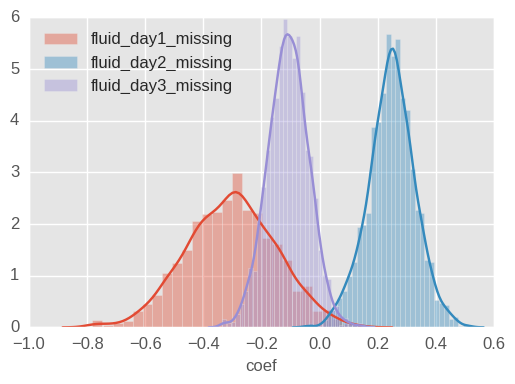

In [67]:
coefs = ['fluid_day1_missing', 'fluid_day2_missing', 'fluid_day3_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')